# Classificação LC

Neste notebook vamos treinar um modelo de regressão logística para predizer a probabilidade de um candidato ser aprovado na prova de línguas e códigos com base nas suas respostas na inscrição do ENEM.

## Carregar pacotes

O código abaixo carrega os pacotes necessários.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm

%matplotlib inline

## Carregar o dataset preparado

Vamos carregar o dataset que foi preparado.

In [2]:
enem = pd.read_csv('../data/enem_preparado.csv')
print(enem.shape)
enem.head()

(171253, 125)


,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,TP_LOCALIZACAO,TP_SIT_FUNC,NU_COMPARECIMENTO_CN_y,PC_APROVACAO_CN_y,NU_COMPARECIMENTO_CH_y,PC_APROVACAO_CH_y,NU_COMPARECIMENTO_LC_y,PC_APROVACAO_LC_y,NU_COMPARECIMENTO_MT_y,PC_APROVACAO_MT_y
0,170005778262,2017,2108900,Poção de Pedras,21,MA,20,M,0,3,...,0,0,3049502,0.034,3242965,0.05,3242965,0.008,3049502,0.121
1,170004397810,2017,2108900,Poção de Pedras,21,MA,21,M,0,3,...,0,0,3049502,0.034,3242965,0.05,3242965,0.008,3049502,0.121
2,170000870390,2017,2108900,Poção de Pedras,21,MA,30,M,1,2,...,0,0,3049502,0.034,3242965,0.05,3242965,0.008,3049502,0.121
3,170000132887,2017,2108900,Poção de Pedras,21,MA,18,M,0,3,...,0,0,3049502,0.034,3242965,0.05,3242965,0.008,3049502,0.121
4,170004998577,2017,2108900,Poção de Pedras,21,MA,20,M,0,3,...,0,0,3049502,0.034,3242965,0.05,3242965,0.008,3049502,0.121


Existem 125 colunas, 1 número de inscrição, 120 features, e 4 colunas de label, uma para cada prova. Essas features correspondem às respostas dadas pelo candidato na inscrição do ENEM.


O código abaixo apresenta o número de candidatos que foram aprovados e que não foram aprovados na prova LC.

In [3]:
cont_aprov = enem.groupby("LB_APROVADO_LC").size()
print(cont_aprov)

LB_APROVADO_LC
0    169908
1      1345
dtype: int64


Note que apenas 0.76% dos candidatos foram aprovados na prova LC. Esse desbalanceamento vai enviesar o treinamento de qualquer modelo.

## Preparar dados para o modelo Scikit-learn
O código na célula abaixo cria um array numpy com os valores dos labels.

In [4]:
labels = np.array(enem["LB_APROVADO_LC"])

Agora, precisamos criar o vetor de features ou matriz do modelo. Como primeiro passo as variáveis categóricas precisam ser recodificadas no padrão One-Hot.

Decidimos não usar os indicadores de pedidos de atendimento especializado, como deficiência, visto que esses casos representam uma parcela muito pequena da amostra e, assim, terão influência desprezível no treinamento.

Isso é feito no código abaixo.

In [5]:
def encode_string(cat_feature: pd.Series):
    encoder = preprocessing.OneHotEncoder(categories="auto", sparse=False)
    return encoder.fit_transform(cat_feature.values.reshape(-1, 1))

categorical_columns = [
    "TP_FAIXA_ETARIA",
    "TP_SEXO",
    "TP_ESTADO_CIVIL",
    "TP_COR_RACA",
    "TP_NACIONALIDADE",
    "TP_ST_CONCLUSAO",
    "TP_ANO_CONCLUIU",
    "TP_ESCOLA",
    "IN_TREINEIRO",
    "Q001",
    "Q002",
    "Q003",
    "Q004",
    "Q005",
    "Q006",
    "Q007",
    "Q008",
    "Q009",
    "Q010",
    "Q011",
    "Q012",
    "Q013",
    "Q014",
    "Q015",
    "Q016",
    "Q017",
    "Q018",
    "Q019",
    "Q020",
    "Q021",
    "Q022",
    "Q023",
    "Q024",
    "Q025",
    "Q026",
    "Q027",
]

Features = np.empty((enem.shape[0], 0))
for col in categorical_columns:
    temp = encode_string(enem[col])
    Features = np.concatenate([Features, temp], axis = 1)

print(Features.shape)
print(Features[:2, :])    

(171253, 217)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.
  1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0

Em seguida os features numéricos devem ser concatenados ao array numpy executando o código na célula abaixo.

In [6]:
Features = np.concatenate(
    [
        Features,
        enem[
            [
                "PC_APROVACAO_CN_x",
                "PC_APROVACAO_CH_x",
                "PC_APROVACAO_LC_x",
                "PC_APROVACAO_MT_x",
                "PC_APROVACAO_CN_y",
                "PC_APROVACAO_CH_y",
                "PC_APROVACAO_LC_y",
                "PC_APROVACAO_MT_y",
            ]
        ].values,
    ],
    axis=1,
)
print(Features.shape)
print(Features[:2, :])   

(171253, 225)
[[0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    1.    1.    0.    0.    0.    0.    0.    0.    1.    0.
  0.    0.    1.    0.    0.    0.    1.    0.    0.    0.    0.    1.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
  0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.
  0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.
  0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    1.
  0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.
  0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0

Com a codificação as 36 features categóricas originais agora são 217 one-hot features. Com mais 8 features numéricas, existe um total de 225.

O código abaixo divide a amostra em dados de treinamento e de teste.

In [7]:
X_train, X_test, y_train, y_test = ms.train_test_split(Features, labels)

A regressão logística é puramente linear, sem regularização. Por isso não precisamos escalar os features numéricos.

## Construir o modelo de regressão logística

A população é bem desbalanceada, assim temos que aplicar pesos de classe ao modelo para compensar o desbalanceamento. Sckit-learn tem uma função conveniente para estimar os valores do pesos de classe, vamos a usar.

In [8]:
from sklearn.utils.class_weight import compute_class_weight
compute_class_weight('balanced', np.unique(labels), labels)

array([ 0.50395802, 63.66282528])

O código a seguir cria o modelo de regressão logistica, onde usaremos os valores dos pesos de classes obtidos.

In [9]:
logistic_mod = linear_model.LogisticRegression(
    solver="lbfgs", class_weight=[0.526, 10.1]
)
logistic_mod.fit(X_train, y_train)

C:\Users\susum\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=[0.526, 10.1], dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

Vamos examinar os coeficientes da regressão logística.

In [10]:
print(logistic_mod.intercept_)
print(logistic_mod.coef_)

[-1.36511852]
[[ 0.37628596  0.75418165  0.75290859  0.68814623  0.48901888  0.33645507
   0.17064822  0.04958514 -0.17044923  0.19058162  0.02110373 -0.40942405
  -0.39627159 -0.20319145 -0.37778301 -0.40905654 -0.05779442  0.062512
  -0.38942475 -0.32924346 -0.43388291 -0.33540257 -0.27476612 -0.39412029
  -0.37544582 -0.26818355 -0.39664557  0.23633089 -0.21897087 -0.15205225
  -0.53013688  0.48640169 -0.19728521 -0.38228791 -0.32272528 -0.34537356
   0.09644116 -0.03495195  0.49943657 -1.59560129  0.47464751 -0.00835995
   0.3229986  -0.35489445 -0.4450275  -0.18790576 -0.98782771 -0.98079483
  -0.72303746 -0.39178475 -0.15412487 -0.03582541  0.31680529  0.12843504
   0.22165499  0.53232452  0.70163074  0.70771533 -0.30993467  0.3279849
  -0.47677623 -0.20610312 -0.49425524 -0.17057388  0.14773517 -0.38262973
  -0.07868563 -0.26322821 -0.09649439  0.0881804  -0.00966212 -0.07004459
  -0.96001201 -0.32350046  0.04242593 -0.24939502  0.22368829  0.48841361
   0.45624659 -0.34269604 -

Vamos calcular as estimativas de probabilidade para o conjunto de teste.

In [11]:
probabilities = logistic_mod.predict_proba(X_test)
print(probabilities[:15,:])

[[9.91087402e-01 8.91259751e-03]
 [9.99688444e-01 3.11555846e-04]
 [9.75466120e-01 2.45338803e-02]
 [9.89458230e-01 1.05417696e-02]
 [9.94751931e-01 5.24806865e-03]
 [9.99491067e-01 5.08932713e-04]
 [9.99944259e-01 5.57408409e-05]
 [9.96638380e-01 3.36161958e-03]
 [9.97057999e-01 2.94200113e-03]
 [9.98713908e-01 1.28609196e-03]
 [9.99944612e-01 5.53883291e-05]
 [9.99618774e-01 3.81226254e-04]
 [9.99766656e-01 2.33344023e-04]
 [9.98492184e-01 1.50781578e-03]
 [9.98583550e-01 1.41645015e-03]]


Observamos que nos primeiras 20 observações as probabilidades de score $0$ são bastante altas, como era esperado.

## Score and evaluate the classification model

Uma escolha simples para definir o limiar é $0.5$. O código da célula abaixo aplica este limiar inicial para os dados de teste.

In [12]:
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])
scores = score_model(probabilities, 0.5)
print(np.array(scores[:100]))
print(y_test[:100])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Ao que parece o modelo está privilegiando o score $0$.

O código da célula abaixo implementa uma função que computa e mostra as métricas de desempenho.

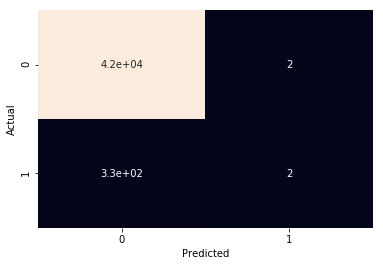


Accuracy 0.99

           Positive      Negative
Num case    42483           331
Precision    0.99          0.50
Recall       1.00          0.01
F1           1.00          0.01


In [13]:
def print_metrics(labels, scores, title=""):
    precision, recall, fscore, support = sklm.precision_recall_fscore_support(
        labels, scores
    )
    matrix = sklm.confusion_matrix(labels, scores)
    sns.heatmap(matrix, annot=True, cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print(title)
    print(f'Accuracy {format(sklm.accuracy_score(labels, scores), "0.2f")}')
    print()
    print("           Positive      Negative")
    print(
        f'Num case   {format(support[0], "6d")}        '
        f'{format(support[1], "6d")}'
    )
    print(
        f'Precision  {format(precision[0], "6.2f")}        '
        f'{format(precision[1], "6.2f")}'
    )
    print(
        f'Recall     {format(recall[0], "6.2f")}        '
        f'{format(recall[1], "6.2f")}'
    )
    print(
        f'F1         {format(fscore[0], "6.2f")}        '
        f'{format(fscore[1], "6.2f")}'
    )
    
print_metrics(y_test, scores)    

Como desconfiamos o modelo está privilegiando o score $0$. Por isso o recall do caso negativo está muito baixo.

Finalmente, o código da célula abaixo computa e mostra a curva ROC e AUC.


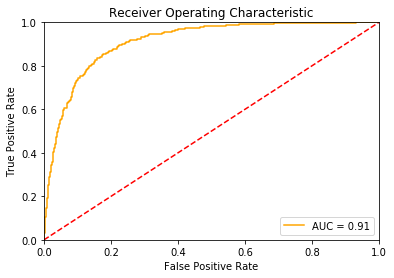

In [14]:
def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'orange', label = f'AUC = {format(auc, "0.2f")}')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_auc(y_test, probabilities)    

Observe que a curva ROC está bem acima do modelo aletório, que indica que nosso modelo não é tão ruim quanto pensávamos talvez seja só uma questão de escolher melhor o limiar.

## Encontrar um limiar melhor

O código da célula abaixo contém uma função para avaliar o módelo para um dado valor de limiar. O loop `for`itera sobre a lista de 9 valores de limiares.


For threshold = 0.45

Accuracy 0.99

           Positive      Negative
Num case    42483           331
Precision    0.99          0.38
Recall       1.00          0.01
F1           1.00          0.02

For threshold = 0.4

Accuracy 0.99

           Positive      Negative
Num case    42483           331
Precision    0.99          0.25
Recall       1.00          0.01
F1           1.00          0.02

For threshold = 0.35

Accuracy 0.99

           Positive      Negative
Num case    42483           331
Precision    0.99          0.28
Recall       1.00          0.02
F1           1.00          0.03

For threshold = 0.3

Accuracy 0.99

           Positive      Negative
Num case    42483           331
Precision    0.99          0.20
Recall       1.00          0.02
F1           1.00          0.04

For threshold = 0.25

Accuracy 0.99

           Positive      Negative
Num case    42483           331
Precision    0.99          0.18
Recall       1.00          0.03
F1           1.00          0.06

F

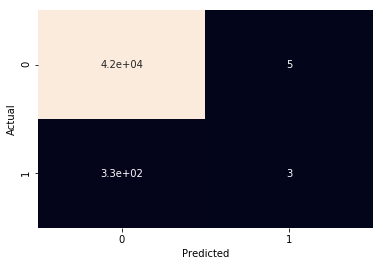

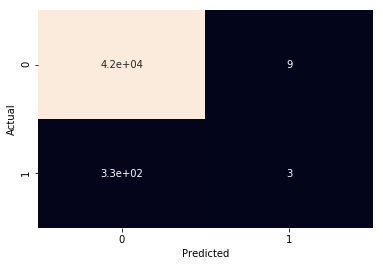

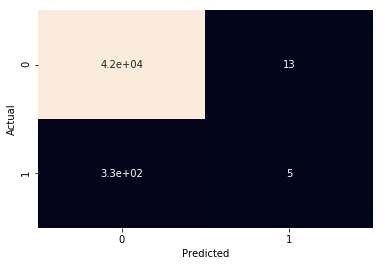

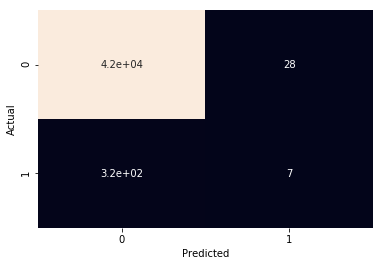

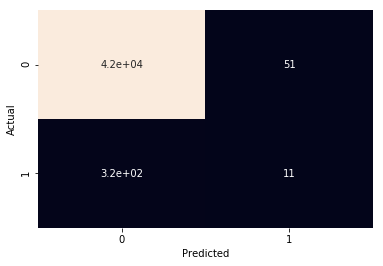

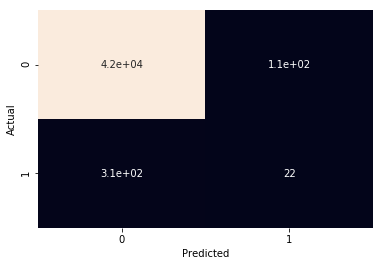

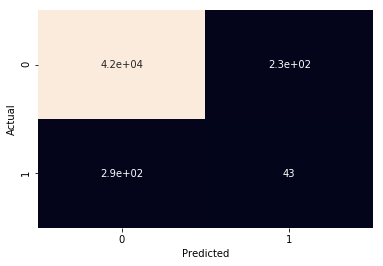

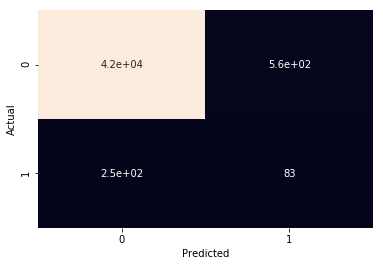

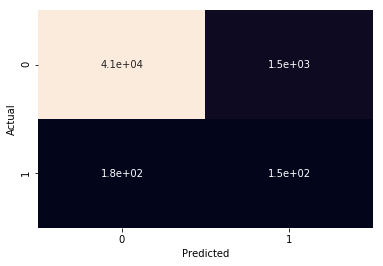

In [15]:
def test_threshold(probs, labels, threshold):
    scores = score_model(probs, threshold)
    print('')
    print(f'For threshold = {threshold}')
    print_metrics(labels, scores)

thresholds = [0.45, 0.40, 0.35, 0.3, 0.25, 0.20, 0.15, 0.10, 0.05]
for t in thresholds:
    test_threshold(probabilities, y_test, t)

O recall melhorou com limiares menores. A escolha do melhor limiar vai depender da aplicação. Pela métrica F1, o melhor valor é por volta de 0.1.

## Execução do caso de produção
Carregar os dados.

In [16]:
producao = pd.read_csv('../data/production_projeto_ENEM_features.csv')
print(producao.shape)
producao.head()

(169814, 109)


,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,170004256309,2017,3129707,Ibiraci,31,MG,20.0,F,0.0,1,...,A,B,B,B,D,A,B,B,A,A
1,170006052305,2017,3538006,Pindamonhangaba,35,SP,17.0,F,0.0,1,...,A,B,A,A,D,A,B,B,B,A
2,170003721524,2017,3137403,Lagoa Dourada,31,MG,18.0,F,0.0,3,...,A,B,A,A,B,A,B,B,B,A
3,170001233897,2017,1502905,Curuçá,15,PA,21.0,M,0.0,3,...,A,B,B,A,D,A,A,A,A,A
4,170000947612,2017,4317509,Santo Ângelo,43,RS,26.0,M,0.0,1,...,A,B,A,A,C,A,A,A,A,A


Resolver os valores ausentes.

In [17]:
producao.drop(
    [
        "CO_MUNICIPIO_NASCIMENTO",
        "NO_MUNICIPIO_NASCIMENTO",
        "CO_UF_NASCIMENTO",
        "SG_UF_NASCIMENTO",
        "TP_ENSINO",
        "CO_MUNICIPIO_ESC",
        "NO_MUNICIPIO_ESC",
        "CO_UF_ESC",
        "SG_UF_ESC",
        "TP_DEPENDENCIA_ADM_ESC",
        "TP_LOCALIZACAO_ESC",
        "TP_SIT_FUNC_ESC",
    ],
    axis=1,
    inplace=True,
)
producao.loc[producao["CO_ESCOLA"].isna(), "CO_ESCOLA"] = 0
producao.loc[producao["NU_IDADE"].isna(), "NU_IDADE"] = 17
producao.loc[producao["TP_ESTADO_CIVIL"].isna(), "TP_ESTADO_CIVIL"] = 0
producao.shape

(169814, 97)

Mudar tipo de dados.

In [18]:
cols = ["NU_IDADE", "TP_ESTADO_CIVIL", "CO_ESCOLA"]
for col in cols:
    producao[col] = pd.to_numeric(producao[col], downcast="integer")
producao[cols].dtypes

NU_IDADE            int8
TP_ESTADO_CIVIL     int8
CO_ESCOLA          int32
dtype: object

Agrupar idade.

In [19]:
criteria = [
    producao["NU_IDADE"] < 15,
    producao["NU_IDADE"] == 15,
    producao["NU_IDADE"] == 16,
    producao["NU_IDADE"] == 17,
    producao["NU_IDADE"] == 18,
    producao["NU_IDADE"] == 19,
    producao["NU_IDADE"] == 20,
    producao["NU_IDADE"] == 21,
    producao["NU_IDADE"] == 22,
    producao["NU_IDADE"] == 23,
    producao["NU_IDADE"] == 24,
    producao["NU_IDADE"] == 25,
    producao["NU_IDADE"] == 26,
    producao["NU_IDADE"] == 27,
    producao["NU_IDADE"] == 28,
    producao["NU_IDADE"] == 29,
    producao["NU_IDADE"] == 30,
    producao["NU_IDADE"].between(31,32),
    producao["NU_IDADE"].between(33,34),
    producao["NU_IDADE"].between(35,36),
    producao["NU_IDADE"].between(37,38),
    producao["NU_IDADE"].between(39,41),
    producao["NU_IDADE"].between(42,45),
    producao["NU_IDADE"].between(46,50),
    producao["NU_IDADE"] > 50,
]
values = [
    "< 15 anos",
    "15 anos",
    "16 anos",
    "17 anos",
    "18 anos",
    "19 anos",
    "20 anos",
    "21 anos",
    "22 anos",
    "23 anos",
    "24 anos",
    "25 anos",
    "26 anos",
    "27 anos",
    "28 anos",
    "29 anos",
    "30 anos",
    "31--32 anos",
    "33--34 anos",
    "35--36 anos",
    "37--38 anos",
    "39--41 anos",
    "42--45 anos",
    "46--50 anos",
    ">50 anos",
]
producao["TP_FAIXA_ETARIA"] = np.select(criteria, values)
producao.head(20)

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,TP_FAIXA_ETARIA
0,170004256309,2017,3129707,Ibiraci,31,MG,20,F,0,1,...,B,B,B,D,A,B,B,A,A,20 anos
1,170006052305,2017,3538006,Pindamonhangaba,35,SP,17,F,0,1,...,B,A,A,D,A,B,B,B,A,17 anos
2,170003721524,2017,3137403,Lagoa Dourada,31,MG,18,F,0,3,...,B,A,A,B,A,B,B,B,A,18 anos
3,170001233897,2017,1502905,Curuçá,15,PA,21,M,0,3,...,B,B,A,D,A,A,A,A,A,21 anos
4,170000947612,2017,4317509,Santo Ângelo,43,RS,26,M,0,1,...,B,A,A,C,A,A,A,A,A,26 anos
5,170002110137,2017,3550308,São Paulo,35,SP,18,M,0,3,...,B,B,A,D,A,B,B,B,A,18 anos
6,170003350533,2017,3549805,São José do Rio Preto,35,SP,21,M,0,1,...,B,A,B,E,B,B,B,A,D,21 anos
7,170001868581,2017,3106200,Belo Horizonte,31,MG,19,M,0,1,...,D,B,B,E,B,C,B,A,D,19 anos
8,170000827807,2017,4314100,Passo Fundo,43,RS,17,M,0,1,...,E,B,B,D,B,D,B,B,A,17 anos
9,170002710405,2017,5003702,Dourados,50,MS,22,F,0,3,...,B,A,A,C,A,B,B,A,A,22 anos


Carregar tabela de municípios e escolas.

In [20]:
municipios = pd.read_csv("../data/municipios.csv")
municipios.head(20)
escolas = pd.read_csv("../data/escolas.csv")
escolas.head(20)

,CO_ESCOLA,CO_MUNICIPIO,TP_DEPENDENCIA_ADM,TP_LOCALIZACAO,TP_SIT_FUNC,NU_COMPARECIMENTO_CN,PC_APROVACAO_CN,NU_COMPARECIMENTO_CH,PC_APROVACAO_CH,NU_COMPARECIMENTO_LC,PC_APROVACAO_LC,NU_COMPARECIMENTO_MT,PC_APROVACAO_MT
0,0,0,0,0,0,3049502,0.034,3242965,0.050,3242965,0.008,3049502,0.121
1,13079220,1301902,4,1,1,26,0.077,26,0.154,26,0.000,26,0.308
2,29422418,2927408,2,1,1,7,0.000,7,0.000,7,0.000,7,0.000
3,35001259,3550308,2,1,1,50,0.000,54,0.000,54,0.000,50,0.020
4,35925950,3545803,2,1,1,100,0.030,102,0.059,102,0.010,100,0.130
5,29428408,2914604,4,1,1,94,0.096,94,0.128,94,0.000,94,0.340
6,35029087,3557105,2,2,1,88,0.000,91,0.044,91,0.000,88,0.068
7,41024397,4115200,4,1,1,106,0.208,106,0.104,106,0.019,106,0.377
8,22015787,2207702,2,1,1,15,0.000,17,0.000,17,0.000,15,0.000
9,29015227,2928109,2,1,1,213,0.000,223,0.004,223,0.000,213,0.023


Join com producao.

In [21]:
producao = pd.merge(
    producao, municipios, left_on="CO_MUNICIPIO_RESIDENCIA", right_on="CO_MUNICIPIO"
)
producao = pd.merge(producao, escolas, on="CO_ESCOLA")
producao.shape

(169814, 121)

Codificar as categorias.

In [22]:
Features = np.empty((producao.shape[0], 0))
for col in categorical_columns:
    temp = encode_string(producao[col])
    Features = np.concatenate([Features, temp], axis = 1)

print(Features.shape)
print(Features[:2, :])    

(169814, 217)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.
  0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.
  0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0

Concatena as colunas numéricas.

In [23]:
Features = np.concatenate(
    [
        Features,
        producao[
            [
                "PC_APROVACAO_CN_x",
                "PC_APROVACAO_CH_x",
                "PC_APROVACAO_LC_x",
                "PC_APROVACAO_MT_x",
                "PC_APROVACAO_CN_y",
                "PC_APROVACAO_CH_y",
                "PC_APROVACAO_LC_y",
                "PC_APROVACAO_MT_y",
            ]
        ].values,
    ],
    axis=1,
)
print(Features.shape)
print(Features[:2, :])   

(169814, 225)
[[0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    1.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
  0.    0.    1.    0.    0.    0.    1.    0.    0.    0.    0.    0.
  1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
  0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.
  0.    0.    0.    0.    1.    0.    0.    0.    1.    0.    0.    0.
  0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.
  0.    0.    1.    0.    0.    0.    0.    0.    0.    1.    0.    0.
  1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    1.    0.
  0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0

Cálculo das probabilidades.

In [25]:
producao["PC_PROBABILIDADE_APROVACAO_LC"] = np.tanh(
    logistic_mod.predict_proba(Features)[:, 1] * 5
)

Escrever resposta para arquivo.

In [27]:
producao[["NU_INSCRICAO", "PC_PROBABILIDADE_APROVACAO_LC"]].to_csv(
    "../data/producao_proba_lc.csv", index=False
)
